In [1]:
import datetime
import pyaurorax
import cartopy.crs
import numpy as np
import pprint

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

# Add contours to mosaics

When generating mosaics you can add contour lines on top. Let"s have a look at some examples of this. We first generate a mosaic like we would in any normal situation, and after we overplot the contours.

Let's have a look at an example.

### **Step 1: Create a Mosaic Object**

In [2]:
# Download a minute of RGB data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
dt = datetime.datetime(2023, 2, 24, 7, 5)
site_uid_list = ["yknf", "gill", "rabb", "luck", "atha"]
data_download_objs = {}
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, dt, dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# Read in the data site-by-site, as we need this separation for mosaicing
data_list = []
for site_uid, download_obj in data_download_objs.items():
    data_list.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

In [3]:
# Download and read the recommended skymap for each site
skymaps = []
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("TREX_RGB_SKYMAP_IDLSAV", site_uid, dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps.append(skymap.data[0])

pprint.pprint(skymaps)

[Skymap(project_uid=rgb, site_uid=yknf, imager_uid=rgb-08, site_map_latitude=62.519848, site_map_longitude=245.686966, ...),
 Skymap(project_uid=rgb, site_uid=gill, imager_uid=rgb-04, site_map_latitude=56.376724, site_map_longitude=265.356323, ...),
 Skymap(project_uid=rgb, site_uid=rabb, imager_uid=rgb-06, site_map_latitude=58.227810, site_map_longitude=256.319366, ...),
 Skymap(project_uid=rgb, site_uid=luck, imager_uid=rgb-03, site_map_latitude=51.153988, site_map_longitude=252.735260, ...),
 Skymap(project_uid=rgb, site_uid=atha, imager_uid=rgb-07, site_map_latitude=54.602631, site_map_longitude=246.355728, ...)]


In [4]:
# prepare the skymap data
prepped_skymap = at.mosaic.prep_skymaps(skymaps, 110, n_parallel=5)

# prepare the image data
prepped_images = at.mosaic.prep_images(data_list)

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

In [5]:
# define the intensity scales for each site
scale = {
    "yknf": [10, 105],
    "gill": [10, 105],
    "rabb": [10, 105],
    "luck": [10, 105],
    "atha": [10, 105],
}

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
mosaic = at.mosaic.create(prepped_images, prepped_skymap, dt, projection_obj, image_intensity_scales=scale)
print(mosaic)

Mosaic(polygon_data=PolyCollection(...), cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


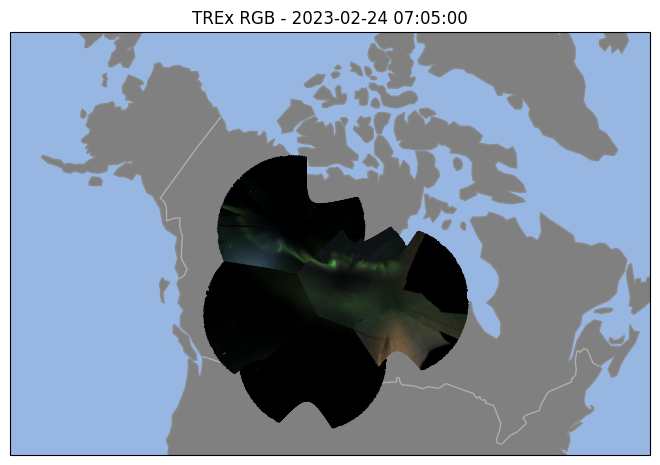

In [6]:
# set the map extent, timestamp, and title
map_extent = [-145, -65, 35, 80]
frame_dt = data_list[0].timestamp[0]
title = "TREx RGB - %s" % (dt.strftime("%Y-%m-%d %H:%M:%S"))

# display the mosaic
mosaic.plot(map_extent, title=title)

# Step 2: Add contours to the mosaic

Now that we have our mosaic, we can add in the contours and the plot it again. The order that contours are added to a `Mosaic` object is the order in which they will be drawn. By default, the contours are plotted on top of the map, but under the image data. Use the `bring_to_front` parameter to plot the contour on top of the image data.

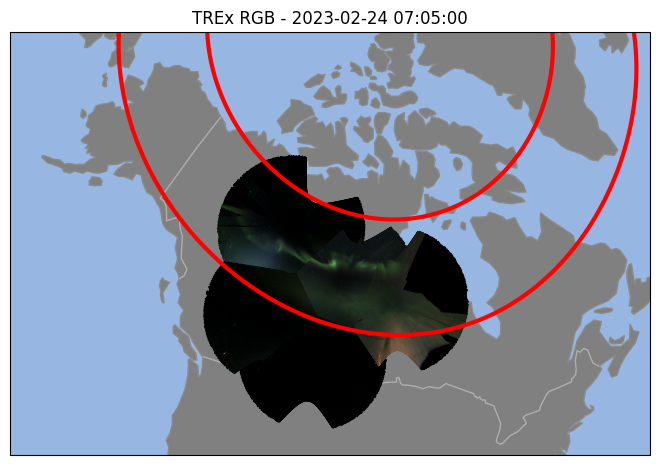

In [7]:
# add a couple lines of constant magnetic latitude
#
# NOTE: we use the bring_to_front parameter here which makes the contour plot
# on top of image data
mosaic.add_mag_contours(dt, constant_lats=[62, 72], color="red", linewidth=3, bring_to_front=True)

# display the mosaic
mosaic.plot(map_extent, title="TREx RGB - %s" % (dt.strftime("%Y-%m-%d %H:%M:%S")))

Now's let's add some geodetic lines under the image data and magnetic contours.

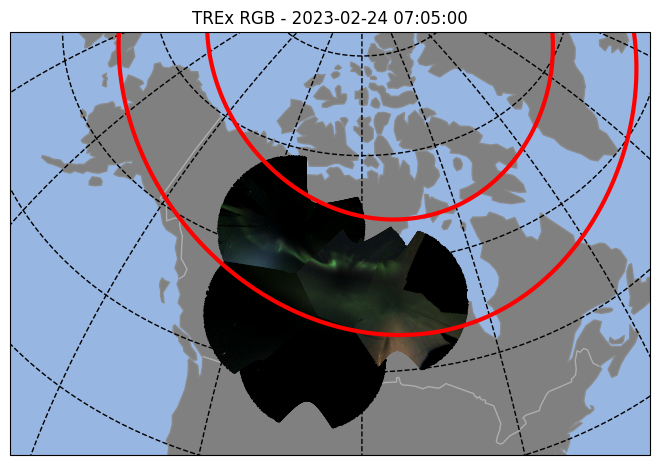

In [8]:
# add geographic gridlines using many lines of constant lat and lon under the image data
lat_locs = np.arange(0, 90, 10)
lon_locs = np.arange(-180, 0, 20)
mosaic.add_geo_contours(constant_lats=lat_locs, constant_lons=lon_locs, linestyle="--", color="black")

# display the mosaic
mosaic.plot(map_extent, title="TREx RGB - %s" % (dt.strftime("%Y-%m-%d %H:%M:%S")))

Finally, let's also add contours defined by a custom set of latitudes and longitudes.

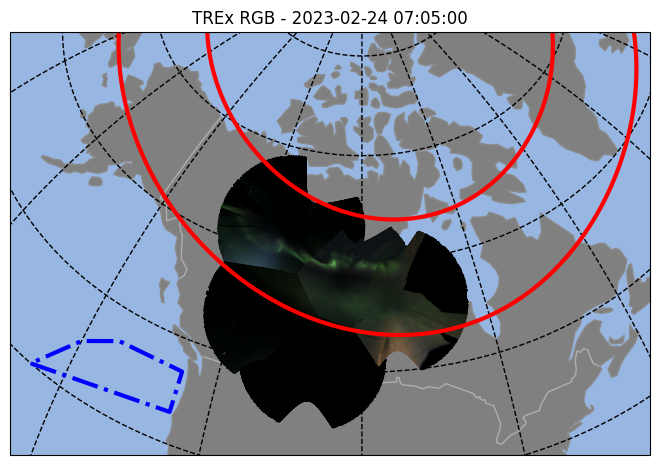

In [9]:
# define some custom contour in lat/lon space
custom_lats = [40, 43, 47, 47, 45, 40]
custom_lons = [-145, -125, -125, -135, -140, -145]

# add geodetic contour and display
mosaic.add_geo_contours(lats=custom_lats, lons=custom_lons, linestyle="dashdot", linewidth=3, color="blue", bring_to_front=True)
mosaic.plot(map_extent, title="TREx RGB - %s" % (dt.strftime("%Y-%m-%d %H:%M:%S")))